In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from imp import reload

from sklearn.cluster import DBSCAN
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV, ParameterGrid
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score

import graphviz 
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
import plotly
import matplotlib.pyplot as plt

from backend import data_handling; reload(data_handling);
from backend import tree_utils; reload(tree_utils);

plotly.offline.init_notebook_mode(connected=True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data = pd.read_csv('data/transactions_fixprice_only.csv', sep=';', encoding='cp1251', parse_dates=['purchdate'])
client_cats = pd.read_csv('data/client_categories.csv', sep=';', encoding='cp1251')
clients = pd.read_csv('data/clients.csv', sep=';', encoding='cp1251')
clients = clients.rename(columns={"categorycode":"category", "cnum_":"cnum"}).copy()

Сводим в одну таблицу

In [3]:
clients = pd.merge(clients, client_cats, how='inner', on = "category")

In [4]:
data1 = pd.merge(clients, data, how='inner', on = 'cnum')

In [5]:
data1
# фичи можно добавить только с purchdate и amount

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,mrchcity,mrchname
0,0DHGSG,81,M,36,married,R,Affluent Banking payroll customer,2019-12-03,500.0,5311,SANKT-PETERBU,94NWJ4I1 FFM
1,0DSXON,81,M,49,married,R,Affluent Banking payroll customer,2019-11-28,738.0,5411,MOSCOW,94NWJ4I1 B6SP
2,0DSXON,81,M,49,married,R,Affluent Banking payroll customer,2019-11-27,63.7,5411,MOSCOW,94NWJ4I1 B6SP
3,0FDDCO,81,M,39,married,R,Affluent Banking payroll customer,2019-10-04,248.0,5499,KRASNOGORSK,94NWJ4I1 G6F
4,0FDDCO,81,M,39,married,R,Affluent Banking payroll customer,2019-11-24,242.5,5499,KRASNOGORSK,94NWJ4I1 G6F
5,0FDDCO,81,M,39,married,R,Affluent Banking payroll customer,2019-10-20,110.0,5499,KRASNOGORSK,94NWJ4I1 G6F
6,0FDDCO,81,M,39,married,R,Affluent Banking payroll customer,2019-12-14,105.0,5499,KRASNOGORSK,94NWJ4I1 G6F
7,0FDDCO,81,M,39,married,R,Affluent Banking payroll customer,2019-11-23,100.0,5499,KRASNOGORSK,94NWJ4I1 G6F
8,0FGCXG,81,M,43,married,R,Affluent Banking payroll customer,2019-12-14,254.0,5311,CHEREPOVECZ,94NWJ4I1 BVSF
9,0FGCXG,81,M,43,married,R,Affluent Banking payroll customer,2019-12-10,254.0,5311,CHEREPOVECZ,94NWJ4I1 6FP


# Feature Engineering

In [6]:
# фичи можно добавить только с purchdate и amount
# purchdate -> days_since_first_order(recency), days_since_last_order, frequency
# amount -> overall_amount(Monetary), order_sum, avg_amount_in_3_last_trans
# 
# мы можем прогнозозировать не только отток, но и уход к конкуренту
# 
# for i in data1.cnum.unique():
    

In [7]:
data1 = pd.merge(data1, data1.sort_values(['purchdate']).groupby('cnum').head(1).loc[:, ["purchdate", 'cnum']].rename(columns={"purchdate":"first_trans"}), on='cnum',
         how='left')

# Recency

In [8]:
data1['days_since_first_order'] = (data1.purchdate - data1.first_trans)

In [9]:
tmp = data1.drop_duplicates(subset=['cnum','purchdate']).sort_values(['purchdate'])[['cnum', 'purchdate', 'amount']]

In [10]:
tmp['days_since_last_order']  = tmp.groupby('cnum')['purchdate'].diff().apply(lambda x: x.days)

In [11]:
tmp = tmp[['cnum', 'purchdate', 'days_since_last_order']]

In [12]:
tmp.dropna(subset=['days_since_last_order'], inplace=True)

In [13]:
tmp['order_sum'] = 1
tmp.order_sum = tmp.groupby(['cnum']).order_sum.cumsum()

In [14]:
df = pd.merge(data1, 
         tmp,
         on=['cnum','purchdate'],
         how='left'
)


проверка таргета

In [15]:
df[df.cnum == 'EEPLLD'].sort_values("purchdate").head(50)

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,mrchcity,mrchname,first_trans,days_since_first_order,days_since_last_order,order_sum
63323,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-14,34.0,5311,POLEVSKOJ,94NWJ4I1 B5G6,2019-10-14,0 days,NaN,NaN
63317,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-15,34.0,5311,REVDA,94NWJ4I1 BGPS,2019-10-14,1 days,1.0,1.0
63324,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-21,34.0,5311,EKATERINBURG,94NWJ4I1 QMPP,2019-10-14,7 days,6.0,2.0
63328,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-29,27.5,5311,POLEVSKOJ,94NWJ4I1 B5G6,2019-10-14,15 days,8.0,3.0
63327,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-29,27.5,5311,POLEVSKOJ,94NWJ4I1 B5G6,2019-10-14,15 days,8.0,3.0
63320,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-30,34.0,5311,EKATERINBURG,94NWJ4I1 5FQS,2019-10-14,16 days,1.0,4.0
63326,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-11-01,27.5,5311,EKATERINBURG,94NWJ4I1 Q5VV,2019-10-14,18 days,2.0,5.0
63311,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-11-02,55.0,5311,PERVOURALSK,94NWJ4I1 BBGV,2019-10-14,19 days,1.0,6.0
63310,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-11-04,55.0,5311,REVDA,94NWJ4I1 BQVM,2019-10-14,21 days,2.0,7.0
63308,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-11-05,82.5,5311,POLEVSKOJ,94NWJ4I1 B5G6,2019-10-14,22 days,1.0,8.0


Модель оттока

C:\Users\Ivan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



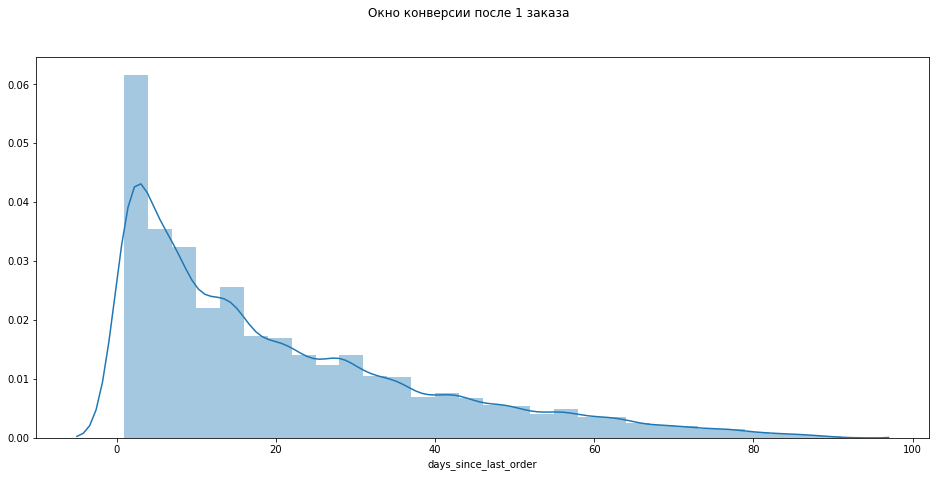

In [16]:
f, ax = plt.subplots(1, figsize=(16, 7))
f.suptitle('Окно конверсии после 1 заказа')
sns.distplot(df.query("order_sum == 1").days_since_last_order, bins=30, ax=ax)

In [17]:
np.percentile(df.query("order_sum == 1").days_since_last_order, 95)

60.0

Будем считать, что если клиент не делает второй заказ уже 48 дней, то он скорее всего его и не сделает.

In [18]:
np.percentile(df.query("order_sum > 1").days_since_last_order, 95)

30.0

Если у человека уже не первый заказ, то в худшем случае окно конверсии 20 дней. Будем считать, что клиент ушёл, если он не делает заказ уже 20 дней. Удаляю пользователей, которые появились в бд в первые 20 дней. (Потому что считать заказы в этот период "новыми" неправильно. Будет смещение)

In [19]:
valid_users = df[df.first_trans > df.purchdate.min() + pd.DateOffset(20)].cnum.unique()

In [20]:
df['days_since_first_order'] = df.days_since_first_order.apply(lambda x: x.days)

clients_one_order = df.groupby('cnum').days_since_first_order.max().reset_index().query('days_since_first_order == 0').cnum.unique()
df.loc[df.cnum.isin(clients_one_order), 'target_one_order'] = 1
df.target_one_order = df.target_one_order.fillna(0)

In [21]:
old_clients = (((df.purchdate.max() - df.groupby('cnum').purchdate.max()) / np.timedelta64(1, 'D')).reset_index().query("purchdate > 20")).cnum.unique()

In [22]:
#Таргет последних трёх заказов клиента
df.loc[df[df.cnum.isin(old_clients)].groupby('cnum').tail(3).index, 'target_last_3_orders'] = 1

#Таргет последних двух заказов клиента
df.loc[df[df.cnum.isin(old_clients)].groupby('cnum').tail(2).index, 'target_last_2_orders'] = 1

#Таргет последнего заказа клиента
df.loc[df[df.cnum.isin(old_clients)].groupby('cnum').tail(1).index, 'target_last_1_orders'] = 1

Откидываю последние 48 дней, потому что окно конверсии в случае не первого заказа 48 дней

In [23]:
data = df[(df.cnum.isin(valid_users)) & (df.purchdate < df.purchdate.max() - pd.DateOffset(48))]

In [24]:
cols_target = ['category', 'married_', 'residenttype', 'mrchcity', 'mrchname', 'cnum','description','purchdate',
               'mcc','first_trans','target_one_order']

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else  0)
data['married'] = data['married_'].apply(lambda x: 1 if x == 'married' else  0)

In [25]:
# data['days_since_first_order'] = data['days_since_first_order'] / np.timedelta64(1, 'D')
# df['days_since_first_order'] = df['days_since_first_order'] / np.timedelta64(1, 'D')

In [26]:
data.head()

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,...,mrchname,first_trans,days_since_first_order,days_since_last_order,order_sum,target_one_order,target_last_3_orders,target_last_2_orders,target_last_1_orders,married
3,0FDDCO,81,1,39,married,R,Affluent Banking payroll customer,2019-10-04,248.0,5499,...,94NWJ4I1 G6F,2019-10-04,0,NaN,NaN,0.0,NaN,NaN,NaN,1
5,0FDDCO,81,1,39,married,R,Affluent Banking payroll customer,2019-10-20,110.0,5499,...,94NWJ4I1 G6F,2019-10-04,16,16.0,1.0,0.0,NaN,NaN,NaN,1
16,0FGSGY,81,1,47,married,R,Affluent Banking payroll customer,2019-10-11,1795.0,5499,...,94NWJ4I1 5VBM,2019-10-11,0,NaN,NaN,0.0,1.0,NaN,NaN,1
17,0FGSGY,81,1,47,married,R,Affluent Banking payroll customer,2019-10-13,649.7,5311,...,94NWJ4I1 QFGV,2019-10-11,2,2.0,1.0,0.0,1.0,1.0,NaN,1
18,0FGSGY,81,1,47,married,R,Affluent Banking payroll customer,2019-10-16,566.0,5311,...,94NWJ4I1 QFGV,2019-10-11,5,3.0,2.0,0.0,1.0,1.0,1.0,1


### Fit RF model

In [48]:
clf = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=500, criterion='gini', 
                            random_state=1, n_jobs=-1)

targets = ['target_last_3_orders', 'target_last_2_orders', 'target_last_1_orders']
X, y = data.drop(cols_target+targets, axis=1).fillna(0), data[targets[0]].fillna(0)
X_train, y_train = X[:14000], y[:14000]

clf = clf.fit(X_train, y_train)

feature_names = X_train.columns
tree_utils.get_most_probable_classification_ensemble_paths(clf, feature_names, 5)

,segment,class_1_proba
0,days_since_last_order <= 0.50; married <= 0....,0.8472906403940886
1,gender > 0.50; days_since_last_order <= 0.50...,0.8471720818291215
2,days_since_last_order <= 0.50; amount <= 52.45;,0.8441988950276244
3,days_since_last_order <= 0.50; amount <= 51.60;,0.8425925925925926
4,order_sum <= 1.50; days_since_last_order <= ...,0.8390804597701149


In [49]:
# data_handling.save_to_pickle(clf, 'in/churn_prediction_model.pickle')
# data_handling.save_to_pickle(feature_names, 'in/churn_prediction_model_features.pickle')

### Fit XGB model

In [70]:
data = data.drop(cols_target, axis=1)
targets = ['target_last_3_orders', 'target_last_2_orders', 'target_last_1_orders']

X, y = data.drop(targets, axis=1), data[targets]

X_train, y_train = X[:14000], y[:14000]

In [ ]:

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

KeyError: "['target_last_3_orders' 'target_last_2_orders' 'target_last_1_orders'] not found in axis"

In [121]:
data

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,mrchcity,mrchname,first_trans,days_since_first_order,days_since_last_order,order_sum,target_one_order
0,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-10-29,3551.13,5411,MOSCOW,WO7E1JXIA37,2019-10-07,22.0,6.0,4.0,0.0
9,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-10-16,2285.55,5411,MOSCOW,WO7E1JXIA37,2019-10-07,9.0,9.0,1.0,0.0
10,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-10-07,2264.85,5411,MOSCOW,WO7E1JXIA37,2019-10-07,0.0,NaN,NaN,0.0
11,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-10-23,2248.56,5411,MOSCOW,WO7E1JXIA37,2019-10-07,16.0,3.0,3.0,0.0
13,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-10-20,1856.73,5411,MOSCOW,WO7E1JXIA37,2019-10-07,13.0,4.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4479828,ZSCHFN,82,M,65,married,R,Affluent Banking potential regular customer,2019-10-31,66.48,5411,YAROSLAVL,WO7E1JXIA37 MQSPV,2019-10-29,2.0,2.0,1.0,0.0
4479829,ZYCDNN,82,F,41,not_married,R,Affluent Banking potential regular customer,2019-10-09,744.53,5411,KOLOMNA,WO7E1JXIA37 Q5SG,2019-10-09,0.0,NaN,NaN,1.0
4479830,ZYCNOC,82,M,65,not_married,R,Affluent Banking potential regular customer,2019-10-27,76.99,5411,DERBYSHI,WO7E1JXIA37 MQ6BS,2019-10-27,0.0,NaN,NaN,1.0
4479903,MFONDN,61,F,61,not_married,R,RBA employees (family),2019-10-14,37.99,5411,MOSCOW,WO7E1JXIA37,2019-10-14,0.0,NaN,NaN,1.0


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields cnum, gender, married_, residenttype, description, purchdate, mrchcity, mrchname, first_trans

In [139]:
data

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,mrchcity,mrchname,first_trans,days_since_first_order,days_since_last_order,order_sum,target_last_3_orders,target_last_2_orders,target_last_1_orders
0,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-10-29,3551.13,5411,MOSCOW,WO7E1JXIA37,2019-10-07,22 days,6.0,4.0,NaN,NaN,NaN
1,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-11-20,3441.89,5411,MOSCOW,WO7E1JXIA37,2019-10-07,44 days,8.0,8.0,NaN,NaN,NaN
2,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-12-08,3214.62,5411,MOSCOW,WO7E1JXIA37,2019-10-07,62 days,5.0,12.0,NaN,NaN,NaN
3,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-11-05,3081.34,5411,MOSCOW,WO7E1JXIA37,2019-10-07,29 days,7.0,5.0,NaN,NaN,NaN
4,0CCCOD,81,M,36,not_married,R,Affluent Banking payroll customer,2019-11-25,2877.71,5411,MOSCOW,WO7E1JXIA37,2019-10-07,49 days,5.0,9.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4479922,JTLRQT,51,M,53,married,R,Corporate customer employee/ payroll scheme (f...,2019-09-21,1123.58,5411,SANKT-PETERBU,WO7E1JXIA37 BV,2019-09-16,5 days,5.0,1.0,NaN,NaN,NaN
4479923,JTLRQT,51,M,53,married,R,Corporate customer employee/ payroll scheme (f...,2019-09-21,830.96,5411,SANKT-PETERBU,WO7E1JXIA37 M5,2019-09-16,5 days,5.0,1.0,NaN,NaN,NaN
4479924,JTLRQT,51,M,53,married,R,Corporate customer employee/ payroll scheme (f...,2019-09-24,714.76,5411,SANKT-PETERBU,WO7E1JXIA37 MFG,2019-09-16,8 days,3.0,2.0,1.0,NaN,NaN
4479925,JTLRQT,51,M,53,married,R,Corporate customer employee/ payroll scheme (f...,2019-09-29,437.49,5411,SANKT-PETERBU,WO7E1JXIA37 M5,2019-09-16,13 days,1.0,5.0,1.0,1.0,NaN
